# Training: RGB Image

In [1]:
import torch
import warnings
import torch.nn.functional as F
import numpy as np 
import io
from datasets import load_dataset
from IPython.display import display, Image, update_display, HTML
from torchvision.transforms import ToPILImage, RandomCrop, PILToTensor
from fastprogress.fastprogress import master_bar, progress_bar
from walloc import walloc

README.md:   0%|          | 0.00/611 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/89 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/89 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/85 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/39.2k [00:00<?, ?B/s]

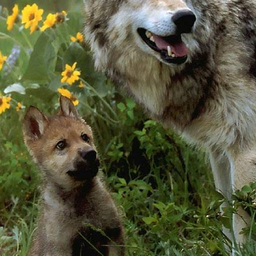

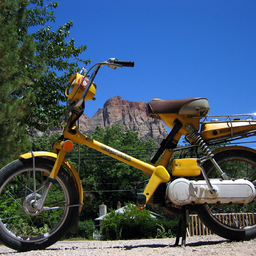

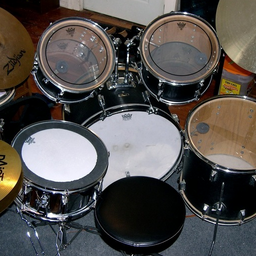

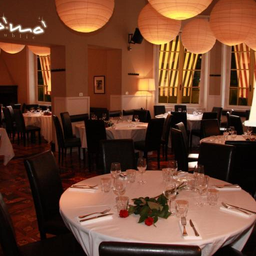

In [2]:
device = "cuda:0"
train_dataset = load_dataset("danjacobellis/LSDIR_540", split="train")
valid_dataset = load_dataset("danjacobellis/imagenet_hq", split="validation")

def collate_fn(batch):
    return torch.cat([
        PILToTensor()(RandomCrop(256)(sample['image'])).unsqueeze(0) for sample in batch
    ])

dataloader_valid = torch.utils.data.DataLoader(
    valid_dataset.select([1,7,30,33]),
    batch_size=4,
    num_workers=12,
    drop_last=True,
    shuffle=False,
    collate_fn=collate_fn
)

valid_batch = next(iter(dataloader_valid))
valid_batch = valid_batch/255
valid_batch = valid_batch - 0.5
valid_batch = valid_batch.to(device)

for img in valid_batch:
    display(ToPILImage()(img+0.5))

In [3]:
class Config: pass
config = Config()
config.batch_size = 64
config.num_workers = 12
config.grad_accum_steps = 1
config.plot_update = 128
config.patience = 64
config.min_lr = 1e-7
config.max_lr = 3e-5
config.warmup_steps = 50000
config.weight_decay = 0.
config.epochs = 250
config.ϕ = 1.

config.channels=3
config.J = 4
config.Ne = 1536
config.Nd = 768
config.latent_dim = 48
config.latent_bits = 4
config.lightweight_encode = False

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import diffusers.models.autoencoders as autoencoders
import einops
import kornia
from pytorch_wavelets import DWTForward, DWTInverse
from walloc.walloc import ToNormal, ToUniform, Round

class Codec2D_ADLoss(nn.Module):
    def __init__(self, channels, J, Ne, Nd, latent_dim, latent_bits, lightweight_encode):
        super().__init__()
        self.channels = channels
        self.J = J
        self.freq_bands = 4**J
        self.Ne = Ne
        self.Nd = Nd
        self.latent_dim = latent_dim
        self.latent_bits = latent_bits
        self.latent_max = 2**(latent_bits-1)-1+0.5-1e-3
        self.wt  = DWTForward(J=1, mode='periodization', wave='bior4.4')
        self.iwt = DWTInverse(mode='periodization', wave='bior4.4')
        self.clamp = torch.nn.Hardtanh(min_val=-0.5, max_val=0.5)

        entropy_bottleneck = [
            ToUniform(
                scale = (2**(latent_bits-1)-1)/1.85,
                latent_max = self.latent_max
            ),
            Round(), 
        ]

        if lightweight_encode:
            self.encoder = nn.Sequential(
                nn.Conv2d(
                    in_channels=self.channels * self.freq_bands,
                    out_channels=self.latent_dim,
                    kernel_size=(1, 1),
                    stride=(1, 1),
                    padding=(0, 0),
                ),
                *entropy_bottleneck
            )
        else:
            self.encoder = nn.Sequential(
                autoencoders.autoencoder_kl.Encoder(
                    in_channels=self.channels * self.freq_bands,
                    out_channels=self.latent_dim,
                    down_block_types=('DownEncoderBlock2D',),
                    block_out_channels=(Ne,),
                    layers_per_block=2,
                    norm_num_groups=32,
                    act_fn='silu',
                    double_z=False,
                    mid_block_add_attention=True,
                ),
                *entropy_bottleneck
            )
            
        self.decoder = nn.Sequential(
            ToNormal(
                scale = (2**(latent_bits-1)-1)/1.85,
                latent_max = self.latent_max
            ),
            autoencoders.autoencoder_kl.Decoder(
                in_channels = self.latent_dim,
                out_channels = self.channels*self.freq_bands,
                up_block_types = ('UpDecoderBlock2D',),
                block_out_channels = (Nd,),
                layers_per_block = 2,
                norm_num_groups = 32,
                act_fn = 'silu',
                mid_block_add_attention=True,
            ),
        )
        
    def analysis_one_level(self,x):
        L, H = self.wt(x)
        X = torch.cat([L.unsqueeze(2),H[0]],dim=2)
        X = einops.rearrange(X, 'b c f h w -> b (c f) h w')
        return X
    
    def wavelet_analysis(self,x,J=3):
        for _ in range(J):
            x = self.analysis_one_level(x)
        return x
    
    def synthesis_one_level(self,X):
        X = einops.rearrange(X, 'b (c f) h w -> b c f h w', f=4)
        L, H = torch.split(X, [1, 3], dim=2)
        L = L.squeeze(2)
        H = [H]
        y = self.iwt((L, H))
        return y
    
    def wavelet_synthesis(self,x,J=3):
        for _ in range(J):
            x = self.synthesis_one_level(x)
        return x
            
    def forward(self,x,kernel_size=(5, 5),sigma_color=0.1,sigma_space=(1.5, 1.5)):
        X = self.wavelet_analysis(x, J=self.J)
        Y = self.encoder(X)
        X_hat = self.decoder(Y)
        x_hat = self.wavelet_synthesis(X_hat, J=self.J)

        x_blur = kornia.filters.bilateral_blur(
            x, kernel_size, sigma_color, sigma_space
        )
        x_hat_blur = kornia.filters.bilateral_blur(
            x_hat, kernel_size, sigma_color, sigma_space
        )
        approximation_loss = F.mse_loss(x_blur, x_hat_blur)

        L, H = self.wt(x)
        D = H[0].abs().mean(dim=1)
        for _ in range(2):
            D, _ = self.wt(D)

        L_hat, H_hat = self.wt(x_hat)
        D_hat = H_hat[0].abs().mean(dim=1)
        for _ in range(2):
            D_hat, _ = self.wt(D_hat)

        detail_loss = F.mse_loss(D, D_hat)

        return self.clamp(x_hat), approximation_loss, detail_loss

In [5]:
codec = Codec2D_ADLoss(
    channels=config.channels,
    J=config.J,
    Ne=config.Ne,
    Nd=config.Nd,
    latent_dim=config.latent_dim,
    latent_bits=config.latent_bits,
    lightweight_encode=config.lightweight_encode
).to(device)

optimizer = torch.optim.AdamW(
    params=codec.parameters(),
    weight_decay=0.0,
    lr = config.min_lr
)

sum(p.numel() for p in codec.parameters())/1e6

251.751984

In [6]:
def minus_cosine_warmup(i_step):
    scale = 0.5 * (np.log10(config.max_lr) - np.log10(config.min_lr))
    angle =  np.pi * i_step / (config.warmup_steps//config.plot_update)
    log_lr = np.log10(config.min_lr) + scale * (1 - np.cos(angle))
    lr = 10 ** log_lr
    return lr/config.min_lr
    
warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: minus_cosine_warmup(i_step)
)

reduce_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.98,
    patience=config.patience,
    threshold=1e-5,
    min_lr=config.min_lr
)

In [ ]:
warnings.filterwarnings("ignore", message="Truncated File Read", category=UserWarning, module="PIL.TiffImagePlugin")
dist_losses, rate_losses = [], []
learning_rates = [optimizer.param_groups[0]['lr']]
img_displays = []
text_display = None
codec.train()
optimizer.zero_grad()
mb = master_bar(range(config.epochs))
mb.names = ['Distortion Loss', 'Smoothed']
i_step = 0
for i_epoch in mb:
    dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        drop_last=True,
        shuffle=True,
        collate_fn=collate_fn
    )
   
    for i, batch in enumerate(progress_bar(dataloader, parent=mb)):
    
        x = batch.to(device)
        x = x.to(torch.float)
        x = x/255
        x = x-0.5

        _, mse_loss, tf_loss = codec(x)

        dist_loss = mse_loss + config.ϕ*tf_loss
        dist_losses.append(np.log10(dist_loss.item()))
        loss = dist_loss
        loss.backward()
        if (i + 1) % config.grad_accum_steps == 0: 
            optimizer.step()
            optimizer.zero_grad()
        
        # plotting and lr scheduler
        if len(dist_losses) % config.plot_update == 0:
            plot_n = len(dist_losses) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(dist_losses).reshape(plot_n, -1).mean(dim=1)
            dist_x = range(len(dist_losses))
            dist_y = dist_losses
            mb.update_graph([[dist_x, dist_y],[smoothed_x, smoothed_y]])
            mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

            # lr scheduler
            if i_step < config.warmup_steps:
                warmup.step()
            else:
                reduce_plateau.step(smoothed_y[-1])
            learning_rates.append(optimizer.param_groups[0]['lr'])

            with torch.no_grad():
                codec.eval()
                y_valid, _, _ = codec(valid_batch)
                codec.train()
            
            for img_idx, img in enumerate(y_valid):
                buffer = io.BytesIO()
                ToPILImage()(img + 0.5).save(buffer, format="PNG")
                # ToPILImage()(img + 0.5).save(f"video/{img_idx}_{i_epoch}_{i}.png")
                buffer.seek(0)
                if len(img_displays) <= img_idx:
                    img_displays.append(display(Image(buffer.read()), display_id=True))
                else:
                    update_display(Image(buffer.read()), display_id=img_displays[img_idx].display_id)
        i_step+=1
        
    torch.save({
        'model_state_dict': codec.state_dict(),
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'dist_losses': dist_losses,
        'config': config
    }, f"log_{device}.pth")

In [9]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

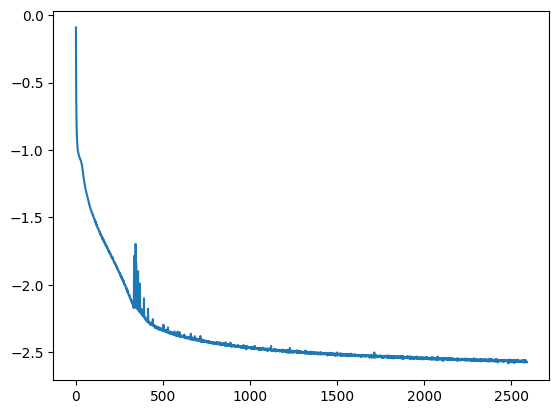

In [10]:
plt.plot(smoothed_y)

In [27]:
mse_loss.item()

0.002250756835564971

In [26]:
tf_loss.item()

0.0002574541140347719

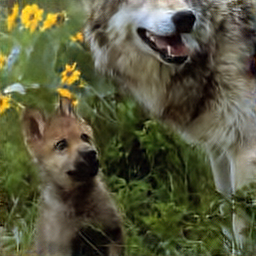

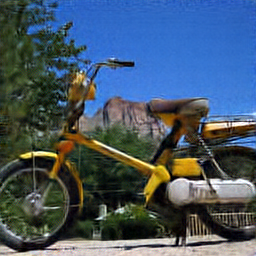

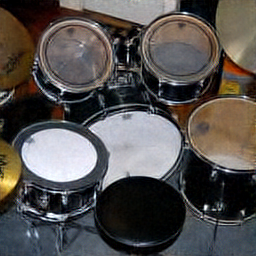

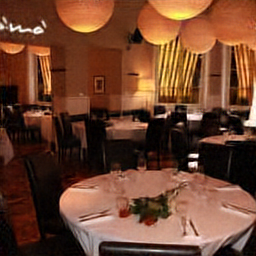

In [11]:
codec.eval()
with torch.no_grad():
    y_valid, _, _ = codec.forward(valid_batch)
for img_idx, img in enumerate(y_valid):
    display(ToPILImage()(img + 0.5))

In [13]:
torch.save({
    'model_state_dict': codec.state_dict(),
}, "../../hf/walloc/RGB_48c_J4_nf4_ADLoss1.pth")

In [14]:
import json
with open('../../hf/walloc/RGB_48c_J4_nf4_ADLoss1.json', 'w') as f:
    json.dump(config.__dict__, f, indent=4)

In [15]:
codec.eval()
with torch.no_grad():
    X = codec.wavelet_analysis(valid_batch,codec.J)
    Z = codec.encoder[:2](X)
    Z2 = codec.encoder(X)

In [16]:
import zlib
bytes = Z.round().to(torch.int8).detach().cpu().numpy().tobytes()
print(valid_batch.numel()/len(bytes))
print(valid_batch.numel()/len(zlib.compress(bytes,level=9)))

16.0
30.38998376999768


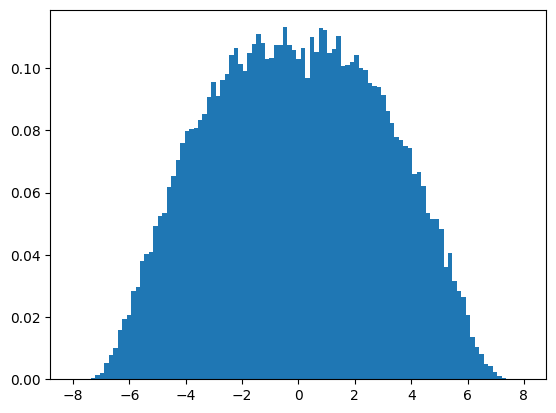

In [18]:
plt.hist(Z.to("cpu").flatten().numpy(), density=True,range=(-8,8),bins=101);

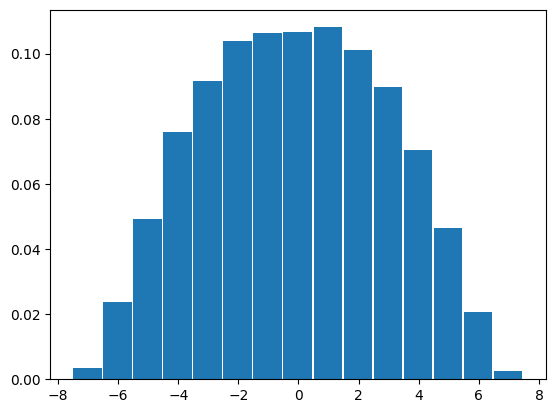

In [23]:
plt.hist(Z2.to("cpu").round().flatten().numpy(), density=True,range=(-7.5, 7.5), bins=15, width=0.95);